# Workshop 5
Hi and welcome to the fifth workshop. In this session we will take a look at a couple of the advanced stress packages because they tend to have input requirements that are somewhat uncommon to the regular stress packages. Specifically we will focus on the lake package (LAK) and the multi-aquifer well package (MAW) to demonstrate how the different data requirements for these packages are developed and used in Flopy objects. We picked the MAW because of applicability and the LAK because it also introduces cell connectivity data input similar to the GWF-GWF package used for linking mutiple models in MF6. Once you have a grasp of the input requirements for these packages the remaining advanced stress packages should not pose a significant obstacle. In addition to the advanced stress package creation we will introduce some of the inbuilt post-processing capabilities of Flopy and provide applied use examples of how they can be used to good effect.

In [1]:
import os
import sys
import shutil
import platform
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy
from flopy.discretization import VertexGrid
from flopy.utils import Raster
from flopy.utils import GridIntersect
from flopy.utils.gridgen import Gridgen
gridgen_exe = "gridgen"
if platform.system() in "Windows":
    gridgen_exe += ".exe"
gridgen_exe = flopy.which("gridgen")
if gridgen_exe is None:
    msg = (
        "Warning, gridgen is not in your path. "
        "When you create the griden object you will need to "
        "provide a full path to the gridgen binary executable."
    )
    print(msg)
else:
    print("gridgen executable was found at: {}".format(gridgen_exe))

print(f"Pandas version = {pd.__version__}")
print(f"Numpy version = {np.__version__}")
print(f"Flopy version = {flopy.__version__}")
print(f"Matplotlib version = {matplotlib.__version__}")

gridgen executable was found at: C:\mffiles\gridgen.EXE
Pandas version = 2.1.1
Numpy version = 1.26.0
Flopy version = 3.4.3
Matplotlib version = 3.8.0


In [2]:
ws5 = os.path.join('workshop_5') # here we are making a path not creating the folder
gis_f = os.path.join(ws5,'GIS') # creating a sub-directory path for our gis input/output
model_f = os.path.join(ws5,'model') # creating a sub-directory path for our model input/output
plots_f = os.path.join(ws5,'plots') # creating a sub-directory path for our plots
for path in [ws5,gis_f,model_f,plots_f]:
    if os.path.exists(path): # here we are asking if the path exists on the computer. 
        shutil.rmtree(path)# if it does exist, delete it and all the files in it
        os.mkdir(path) # then remake it
    else:
        os.mkdir(path) # if it doesn't exist then make the folder

C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\export\shapefile_utils.py:307: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\mf6\mfbase.py:467: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(
C:\ProgramData\miniconda3\envs\model_env\lib\site-packages\flopy\utils\gridgen.py:232: UserWarning: Supplying a dis object is deprecated, and support will be removed in version 3.3.7. Please supply StructuredGrid.
  warnings.warn(


No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package disv...
INFORMATION: nvert in ('gwf6', 'disv', 'dimensions') changed to 25900 based on size of vertices
    writing package npf...
    writing package sto...
    writing package ghb1...
    writing package obs_0...
    writing package ghb2...
    writing package obs_1...
    writing package drn1...
    writing package obs_2...
    writing package drn2...
    writing package obs_3...
    writing package drn3...
    writing package obs_4...
    writing package drn4...
    writing package obs_5...
    writing

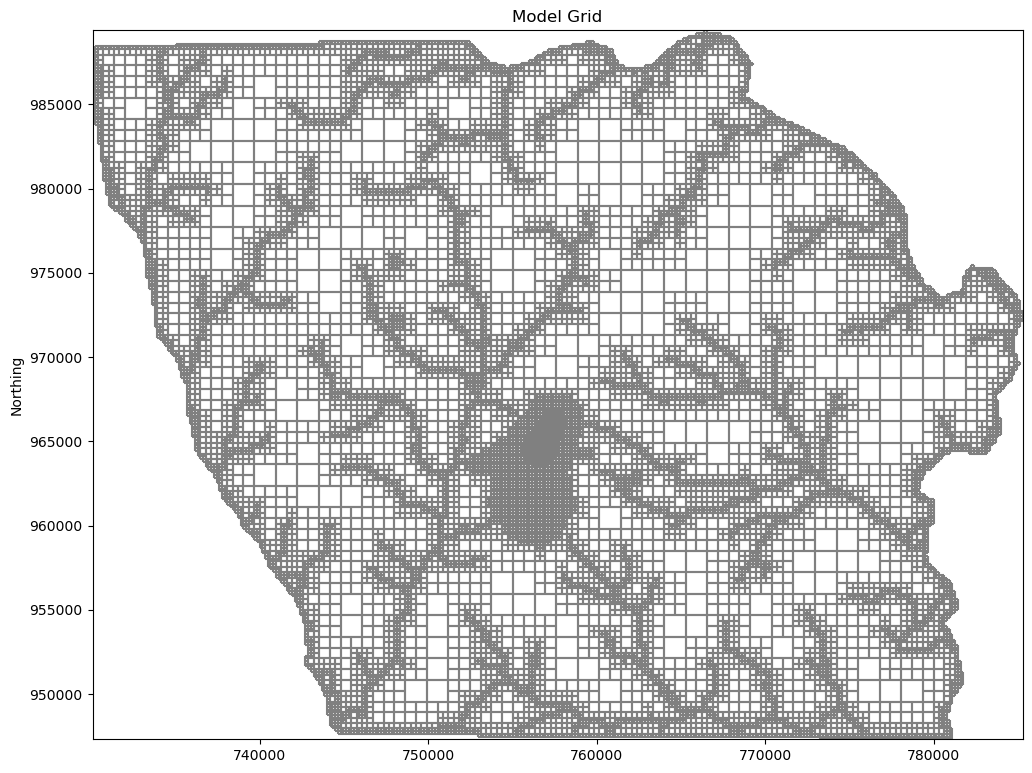

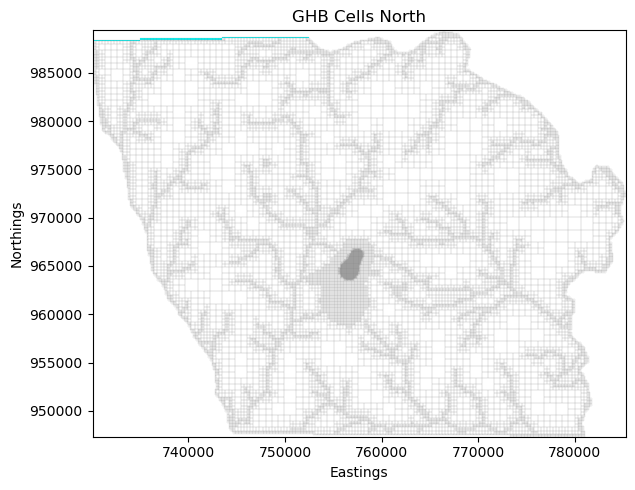

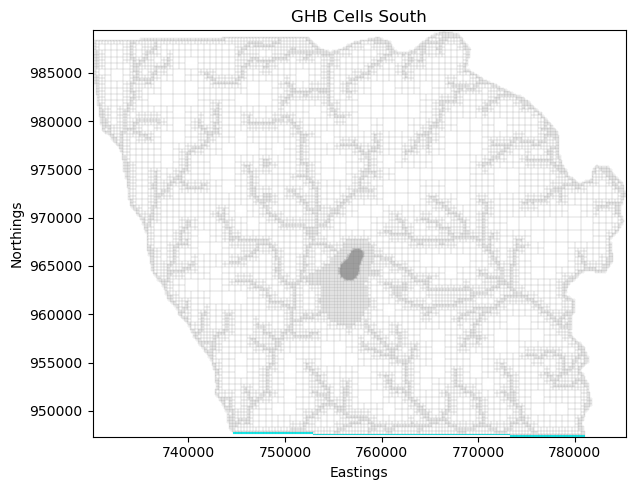

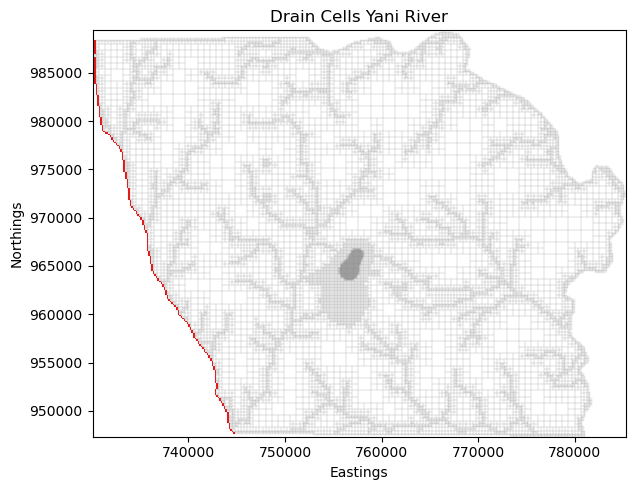

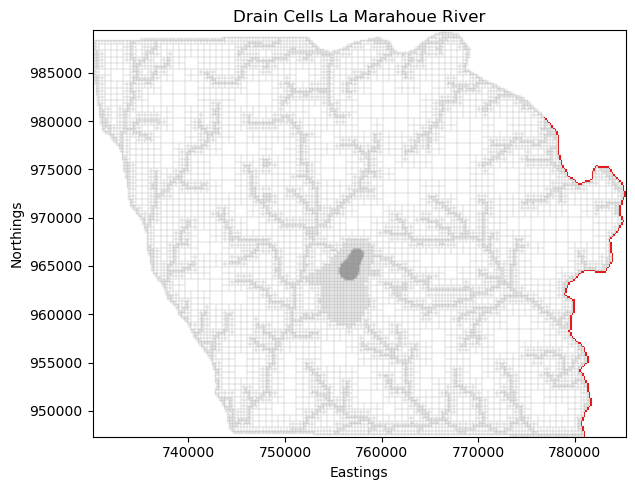

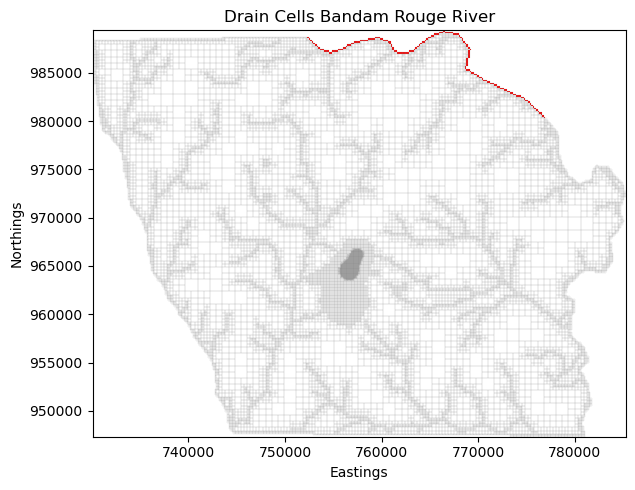

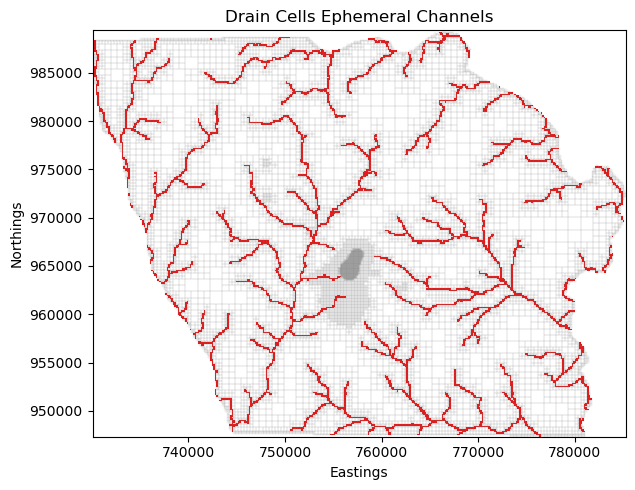

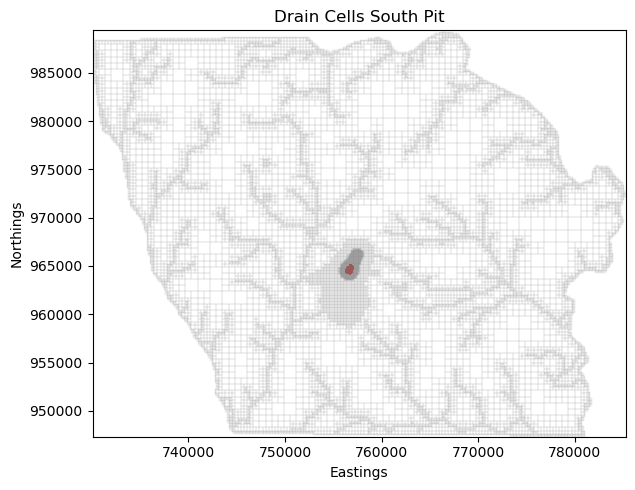

In [3]:
from helpers import ws5_model1
sim, gwf = ws5_model1(ws5,gis_f,model_f,plots_f)

In [4]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Govern

(True, [])

# A summary of the budget

In [5]:
#Take a look at budget summary
lst = flopy.utils.Mf6ListBudget(os.path.join(model_f,"flow.lst"))
start_datetime='31-12-2023'
df_flux, df_vol = lst.get_dataframes()

C:\Users\tarqi\AppData\Local\Temp\ipykernel_3692\1892881735.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  groups = df_flux.groupby(lambda x: x.split("_")[-1], axis=1).groups


Text(0, 0.5, 'ML/d')

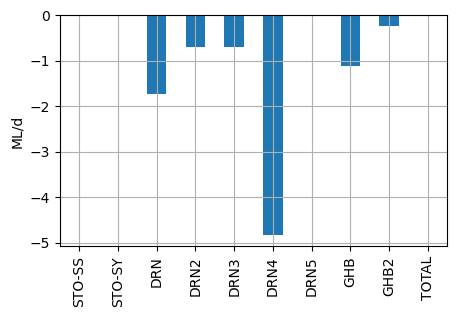

In [6]:
# use the spnum variable to select a specific stress period
spnum = 12
groups = df_flux.groupby(lambda x: x.split("_")[-1], axis=1).groups
df_flux_in = df_flux.loc[:, groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x: x.split("_")[0])

df_flux_out = df_flux.loc[:, groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x: x.split("_")[0])

df_flux_delta = df_flux_in - df_flux_out
df_flux_delta = df_flux_delta*0.001

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
df_flux_delta = df_flux_delta.drop(columns=["RCHA","EVTA"]) # note these are huge in comparison so we are dropping them for now.
df_flux_delta.iloc[spnum, :].plot(kind="bar", grid=True,ax=ax)
plt.ylabel("ML/d")

# Saving the heads for subsequent simualtions

In [7]:
headfile = os.path.join(model_f,"flow.hds")
hds = flopy.utils.binaryfile.HeadFile(headfile)
h = hds.get_data((0,0))
np.savetxt("iheads_array.txt",h[0])
print(np.max(h))

409.3944896083587


# MAW package
Take a look at the MAW package input file in the MF6io.pdf document. You will notice that in addition to an options section you have to specify three other datasets. This includes package data, connection data and stress period data. In this example we will use a shapefile of bore locations to intersect the model grid and obtain the relevant nodes for each well. A function that we used to assign boundary conditions via intersections will be used. This function works for both single and multi-feature shapefiles.

In [8]:
import geopandas as gpd
def get_bnodes(shpfyl): # works with single and multiple line strings
    ix = GridIntersect(mg, method="vertex")
    poly = gpd.read_file(shpfyl).geometry
    if len(poly)==1:
        return(ix.intersect(poly[0]).cellids)
    else:
        ls = []
        for item in poly:
            nums = ix.intersect(item).cellids
            ls = [*ls,*nums]
        return(np.asarray(ls))

In [9]:
# adding in wells for explicit dewatering simulation
mg = gwf.modelgrid
wels = os.path.join(gis_f,"dewatering_wells.shp")
well_nodes = get_bnodes(wels)
wel_gdf = gpd.read_file(wels)
wel_gdf['node'] = well_nodes
wel_gdf.head()

,Bore,star,X UTM -,Y UTM -,Z,months_bef,Bore Depth,estimated_,Pump Depth,Dewatering,Dewateri_1,Dewateri_2,Maintenanc,geometry,node
0,MRBH06,1,756804.6940,964411.9290,373.915,6,163.8,0,150,4,14.4,345.6,2.0,POINT (756804.694 964411.929),13077
1,MRBH015,1,756656.0890,964163.0709,365.426,6,68.0,0,60,8,28.8,691.2,6.0,POINT (756656.089 964163.071),13421
2,MRBH020,0,756629.0305,964077.5871,373.000,6,170.0,1,160,4,14.4,345.6,2.0,POINT (756629.030 964077.587),13447
3,MRBH022,0,756341.4607,964224.6398,377.000,5,180.0,1,160,4,14.4,345.6,2.0,POINT (756341.461 964224.640),13351
4,MRBH017,1,756227.7910,964717.5895,392.000,3,122.0,0,110,1,3.6,86.4,1.0,POINT (756227.791 964717.590),12493


Bore and pump depth are included in the shapefile so we will use this to configure our simulated bores. Note the MAW package offers many different options for well simualtion behaviour and it is useful to know how you cen best utilize the package for your specific simulation. However, in this instance we will adopt the 'THEIM' behaviour option. Each well has a single package data entry but can have multiple connection data entries depending on the different layers intercepted by the screen interval. We only have a three layer model and the wells may or may not reach layer 2. The algorithm below will use the layer elevation data and the bore drill depth to determine the number of connections needed. 

In [10]:
rad = 0.3 # assume all bores have a radius of 0.3 m
condeqn = "THEIM" # the string for setting the MAW behaviour option
pakdata = [] # initialze some empty lists for package data and connection data
condata = []
for i in range(len(wel_gdf)): # for each well
    welnum = i # assign a unique well number
    wel = wel_gdf.loc[i] # get the row entry for the well in the dataframe form the shapefile
    bottom = wel["Z"] - wel["Bore Depth"] # Work out the bottom elevation of the well
    count = 0 # set a count for the number of connections
    node = wel["node"] # this is the node in layer 1 that we got from our function
    start = mg.top[node] # set a starting elevation
    name = wel["Bore"] # get the well name
    for lay in range(3): # nlay =  3 Now loop thorugh each layers bottom elevation for the same node
        if mg.botm[lay][node]>bottom: # conditional on the layer elevation
            entry2 = (welnum,count,(lay,node),1,1,1,1)
            condata.append(entry2)
            count+=1
    entry = (welnum,rad,bottom,start,condeqn,count,name)
    pakdata.append(entry)

In [11]:
pakdata

[(0, 0.3, 210.115, 378.0, 'THEIM', 2, 'MRBH06'),
 (1, 0.3, 297.426, 374.0015563964844, 'THEIM', 1, 'MRBH015'),
 (2, 0.3, 203.0, 375.0, 'THEIM', 2, 'MRBH020'),
 (3, 0.3, 197.0, 376.0, 'THEIM', 2, 'MRBH022'),
 (4, 0.3, 270.0, 393.0, 'THEIM', 2, 'MRBH017'),
 (5, 0.3, 297.93, 371.0083312988281, 'THEIM', 1, 'MRBH018'),
 (6, 0.3, 225.0, 395.0005187988281, 'THEIM', 2, 'MRBH019'),
 (7, 0.3, 207.223, 378.0, 'THEIM', 2, 'MRBH023'),
 (8, 0.3, 283.0, 377.0117492675781, 'THEIM', 1, 'MRBH016')]

In [12]:
condata

[(0, 0, (0, 13077), 1, 1, 1, 1),
 (0, 1, (1, 13077), 1, 1, 1, 1),
 (1, 0, (0, 13421), 1, 1, 1, 1),
 (2, 0, (0, 13447), 1, 1, 1, 1),
 (2, 1, (1, 13447), 1, 1, 1, 1),
 (3, 0, (0, 13351), 1, 1, 1, 1),
 (3, 1, (1, 13351), 1, 1, 1, 1),
 (4, 0, (0, 12493), 1, 1, 1, 1),
 (4, 1, (1, 12493), 1, 1, 1, 1),
 (5, 0, (0, 13387), 1, 1, 1, 1),
 (6, 0, (0, 11151), 1, 1, 1, 1),
 (6, 1, (1, 11151), 1, 1, 1, 1),
 (7, 0, (0, 13089), 1, 1, 1, 1),
 (7, 1, (1, 13089), 1, 1, 1, 1),
 (8, 0, (0, 10845), 1, 1, 1, 1)]

So it looks like some of the wells are only in the first layer while others are in the second layer. Once we have the package and connection data we can configure the stress period data

In [13]:
# Then finally we also need period data
maw_pdata={}
pdata = []
for i in range(len(wel_gdf)):
    wel = wel_gdf.loc[i]
    welnum = i
    r = -wel['Dewateri_2']
    d = wel["Z"] - wel["Pump Depth"]
    l = 1.0
    settings = [[welnum,"status","active"],[welnum,"rate",r],[welnum,"rate_scaling",d,l]]
    pdata = [*pdata,*settings]
maw_pdata[3] = pdata # all wells kick off 9 months prior to mining for this specific scenario
maw_pdata

{3: [[0, 'status', 'active'],
  [0, 'rate', -345.6],
  [0, 'rate_scaling', 223.91500000000002, 1.0],
  [1, 'status', 'active'],
  [1, 'rate', -691.2],
  [1, 'rate_scaling', 305.426, 1.0],
  [2, 'status', 'active'],
  [2, 'rate', -345.6],
  [2, 'rate_scaling', 213.0, 1.0],
  [3, 'status', 'active'],
  [3, 'rate', -345.6],
  [3, 'rate_scaling', 217.0, 1.0],
  [4, 'status', 'active'],
  [4, 'rate', -86.4],
  [4, 'rate_scaling', 282.0, 1.0],
  [5, 'status', 'active'],
  [5, 'rate', -172.8],
  [5, 'rate_scaling', 305.93, 1.0],
  [6, 'status', 'active'],
  [6, 'rate', -259.2],
  [6, 'rate_scaling', 235.0, 1.0],
  [7, 'status', 'active'],
  [7, 'rate', -259.2],
  [7, 'rate_scaling', 217.223, 1.0],
  [8, 'status', 'active'],
  [8, 'rate', -691.2],
  [8, 'rate_scaling', 294.0, 1.0]]}

In [14]:
# Now we can build our package
maw1 = flopy.mf6.ModflowGwfmaw(gwf,boundnames=True,save_flows=True,no_well_storage=True,
                               shutdown_kappa=0.01,
                               mfrcsv_filerecord="maw_reduce.csv",
                               nmawwells=len(well_nodes),
                               packagedata= pakdata, connectiondata= condata , 
                               perioddata = maw_pdata, filename="flow_1.maw")

# Setup obs arrays for drn
ls =[]
for i in range(len(wel_gdf)):
    wel = wel_gdf.loc[i]
    name = wel["Bore"]
    ls.append((name,'maw',name))

obs10_recarray = {
    "maw_obs.csv": ls
}
maw1.obs.initialize(
    filename="flow_1.maw.obs",
    digits=10,
    print_input=True,
    continuous=obs10_recarray,
)

In [15]:
# using hdata from before
ihd_array=np.ones_like(mg.botm)
last_ssheads = np.loadtxt("iheads_array.txt")
ihd_array[:]=last_ssheads

ic = flopy.mf6.ModflowGwfic(
    gwf, pname="ic", strt=ihd_array, filename="flow.ic"
)

In [16]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package sto...
    writing package ghb1...
    writing package obs_0...
    writing package ghb2...
    writing package obs_1...
    writing package drn1...
    writing package obs_2...
    writing package drn2...
    writing package obs_3...
    writing package drn3...
    writing package obs_4...
    writing package drn4...
    writing package obs_5...
    writing package drn5...
    writing package obs_6...
    writing package rch...
    writing package evt...
    writing package oc...
    writing package maw_0...
    writing package obs_7...
    writing package ic...
FloPy is using the following executable to run the model: ..\..\..\..\mffiles\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY 

(True, [])

C:\Users\tarqi\AppData\Local\Temp\ipykernel_3692\1623458268.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  groups = df_flux.groupby(lambda x: x.split("_")[-1], axis=1).groups


Text(0, 0.5, 'ML/d')

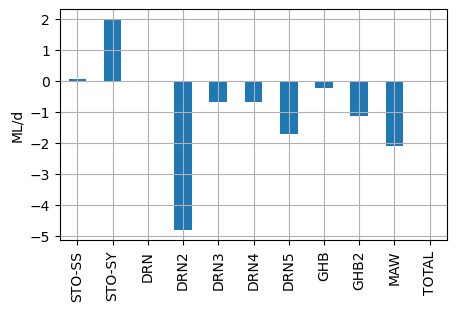

In [17]:
#Take a look at budget summary
lst = flopy.utils.Mf6ListBudget(os.path.join(model_f,"flow.lst"))
start_datetime='31-12-2023'
df_flux, df_vol = lst.get_dataframes()
# use the spnum variable to select a specific stress period
spnum = 12
groups = df_flux.groupby(lambda x: x.split("_")[-1], axis=1).groups
df_flux_in = df_flux.loc[:, groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x: x.split("_")[0])

df_flux_out = df_flux.loc[:, groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x: x.split("_")[0])

df_flux_delta = df_flux_in - df_flux_out
df_flux_delta = df_flux_delta*0.001

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
df_flux_delta = df_flux_delta.drop(columns=["RCHA","EVTA"]) # note these are huge in comparison so we are dropping them for now.
df_flux_delta.iloc[spnum, :].plot(kind="bar", grid=True,ax=ax)
plt.ylabel("ML/d")

(964068.32, 965244.874)

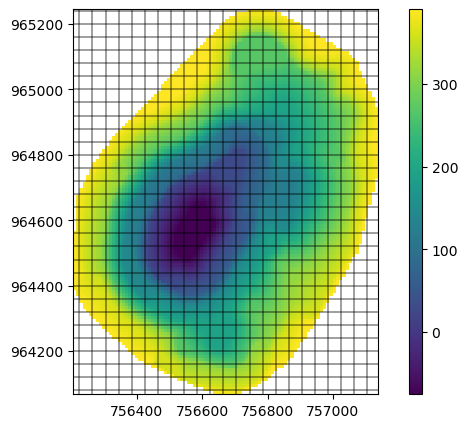

In [33]:
spit_shell = os.path.join(gis_f,'SouthPitShell.tif')
rio = Raster.load(spit_shell)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax = rio.plot(ax=ax)
plt.colorbar(ax.images[0], aspect=30)
pmv = flopy.plot.PlotMapView(modelgrid=mg)
pmv.plot_grid(ax=ax, lw=0.3, color="black")
spit_data = rio.resample_to_grid(
    mg, band=rio.bands[0], method="nearest"
)
ax.set_xlim(rio.bounds[0],rio.bounds[1])
ax.set_ylim(rio.bounds[2],rio.bounds[3])

In [18]:
# A water table cross section
#Lets plot a cross section of heads throough the model
# first we show where the cross section is
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(modelgrid=mg)   
pc = mapview.plot_array(h2, cmap='viridis')
colorbar = plt.colorbar(pc, aspect=30)
contour_set = mapview.contour_array(h2, levels=levels, colors='w',linewidths = 0.75)
ax.clabel(contour_set, fmt='%.1f', colors='w', fontsize=8)
# Plot a shapefile of a cross-section line
shp = os.path.join(gis_f, "cross_sectionAB.shp")
patch_collection = mapview.plot_shapefile(
    shp, radius=0, lw=3, edgecolor="red", facecolor="None"
)
ax.set_title('Heads Layer 1 (mAMSL)',loc='left')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
ax.ticklabel_format(style='plain') #  gets rid of the exponent offsets on the axis
ax.axis('off')
lax,lay = patch_collection._paths[0].vertices[0] # depending on the line this may not be the correct vertex
lbx,lby = patch_collection._paths[0].vertices[1] # same again so be careful with this approach
text_kwargs = dict(fontsize = 16, color = 'k')
plt.text(lax,lay,'A',**text_kwargs,ha='right')
plt.text(lbx,lby,'B',**text_kwargs,ha='left')
#fig.patch.set_visible(False)
plt.tight_layout()

In [29]:
gwf.get_package_list

<bound method ModelInterface.get_package_list of name = flow
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package disv
###################

package_name = disv
filename = flow.disv
package_type = disv
model_or_simulation_package = model
model_name = flow


###################
Package npf
###################

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow


###################
Package sto
###################

package_name = sto
filename = flow.sto
package_type = sto
model_or_simulation_package = model
model_name = flow


###################
Package ghb1
###################

package_name = ghb1
filename = flow_1.ghb
package_type = ghb
model_or_simulation_package = model
model_name = flow


###################
Package obs_0
###################

package_name = obs_0
filename = flow_1.ghb.obs
package_type = obs
model_or_simulation_package = model
model_name = flow
parent_file = ghb1


##########

In [31]:
drn5 = gwf.get_package('drn5')

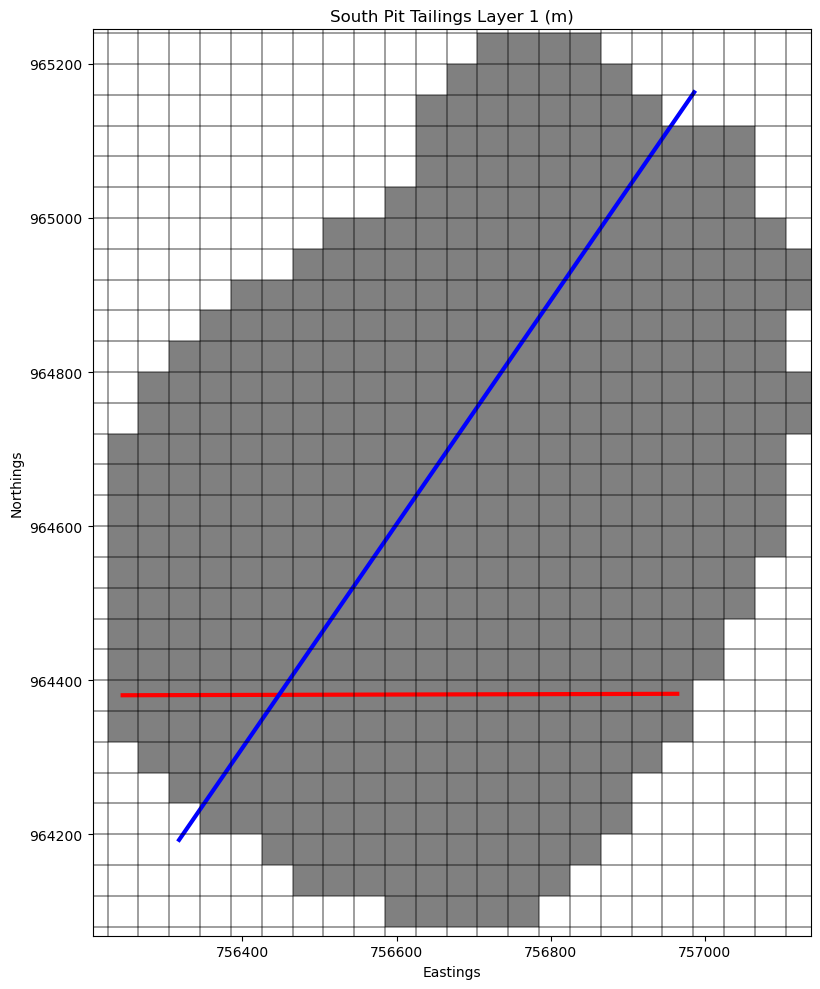

In [36]:
mg=gwf.modelgrid
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mg, layer=0)
pmv.plot_grid(ax=ax, lw=0.3, color="black")
pmv.plot_bc(package=drn5,kper=12, color='grey')
# Plot a shapefile of a cross-section line
shp = os.path.join(gis_f, "cross_section_Spit.shp")
patch_collection = pmv.plot_shapefile(
    shp, radius=0, lw=3, edgecolor="red", facecolor="None"
)
shp2 = os.path.join(gis_f, "cross_section_Spit2.shp")
patch_collection = pmv.plot_shapefile(
    shp2, radius=0, lw=3, edgecolor="blue", facecolor="None"
)
ax.set_xlim(rio.bounds[0],rio.bounds[1])
ax.set_ylim(rio.bounds[2],rio.bounds[3])
ax.set_title('South Pit Tailings Layer 1 (m)')
ax.set_xlabel('Eastings')
ax.set_ylabel('Northings')
ax.ticklabel_format(style='plain') #  gets rid of the exponent offsets on the axis
plt.tight_layout()
fig.savefig('Pit_tailings_coverage.png', dpi=300)

In [19]:
# import styles
from flopy.plot import styles

In [20]:
# getting the extents for the plot
pit1500 = os.path.join(gis_f,"pits_buffer_1500.shp")
gdf1 = gpd.read_file(pit1500)
gdf1.set_crs(epsg=32629)
extents = gdf1.geometry.total_bounds
extents

array([754705.35578945, 962568.60426365, 759030.14402079, 967746.39565337])

In [21]:
# getting a line for the cross section
shp = os.path.join(gis_f, "cross_section_Spit.shp")
gdf = gpd.read_file(shp)
temp = gdf.geometry
x1 = temp.get_coordinates().iloc[0].x
y1 = temp.get_coordinates().iloc[0].y
x2 = temp.get_coordinates().iloc[1].x
y2 = temp.get_coordinates().iloc[1].y
line = {'line':[(x1,y1),(x2,y2)]}
print(x1,y1,x2,y2)

756241.7859503835 964380.4720208534 756967.0967493558 964382.3413785828


In [22]:
headfile1 = os.path.join(model_f,"flow.hds")
hds = flopy.utils.binaryfile.HeadFile(headfile)
h0 = hds.get_data((0,0))
h = hds.get_data((0,12))

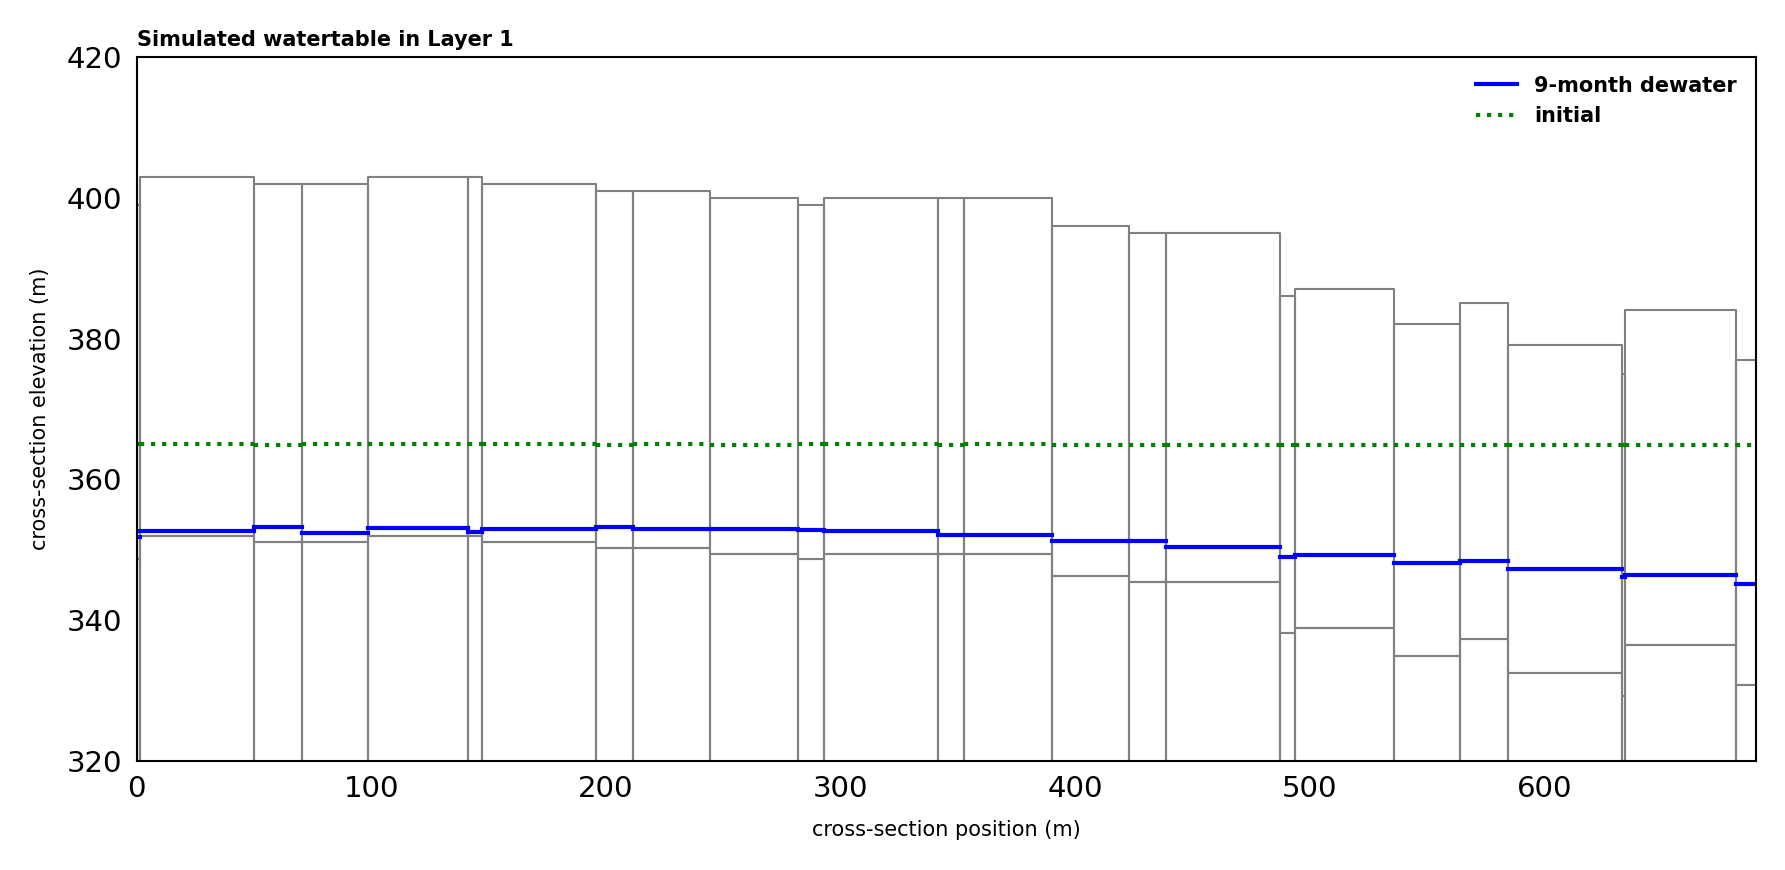

In [39]:
with styles.USGSMap():
    fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=300, tight_layout=True)
    extent = (0.0,690.0,320.0,420.0)
    xsect = flopy.plot.PlotCrossSection(modelgrid=mg, ax=ax, line=line, extent=extent)
    # plot the surface and model grid
    xsect.plot_surface(h0[0],color = "green", lw = 1.0, ls=':', label='initial')
    wt1 = xsect.plot_surface(h[0], color="blue", lw=1.0, label='9-month dewater')
    grd = xsect.plot_grid(lw=0.5)
    styles.xlabel(label="x-position (m)")
    styles.ylabel(label="elevation (m)")
    styles.heading(heading="Simulated watertable in Layer 1",fontsize=5)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    leg = styles.graph_legend(handles = handles, labels=labels, fontsize=5)
    styles.remove_edge_ticks(ax=ax)
    styles.graph_legend_title(leg=leg,title="")
    styles.xlabel(ax=ax,label='cross-section position (m)',fontsize=5)
    styles.ylabel(ax=ax,label='cross-section elevation (m)',fontsize=5)
    ax.set_aspect(3.0)
plt.tight_layout()
fig.savefig(os.path.join(plots_f,'Dewater_cross_section.png'),dpi=300)

In [24]:
shp = os.path.join(gis_f, "cross_section_Spit2.shp")
gdf = gpd.read_file(shp)
temp = gdf.geometry
x1 = temp.get_coordinates().iloc[0].x
y1 = temp.get_coordinates().iloc[0].y
x2 = temp.get_coordinates().iloc[1].x
y2 = temp.get_coordinates().iloc[1].y
line = {'line':[(x1,y1),(x2,y2)]}
print(x1,y1,x2,y2)

756316.214538513 964190.5318049755 756987.8388894219 965165.4047264463


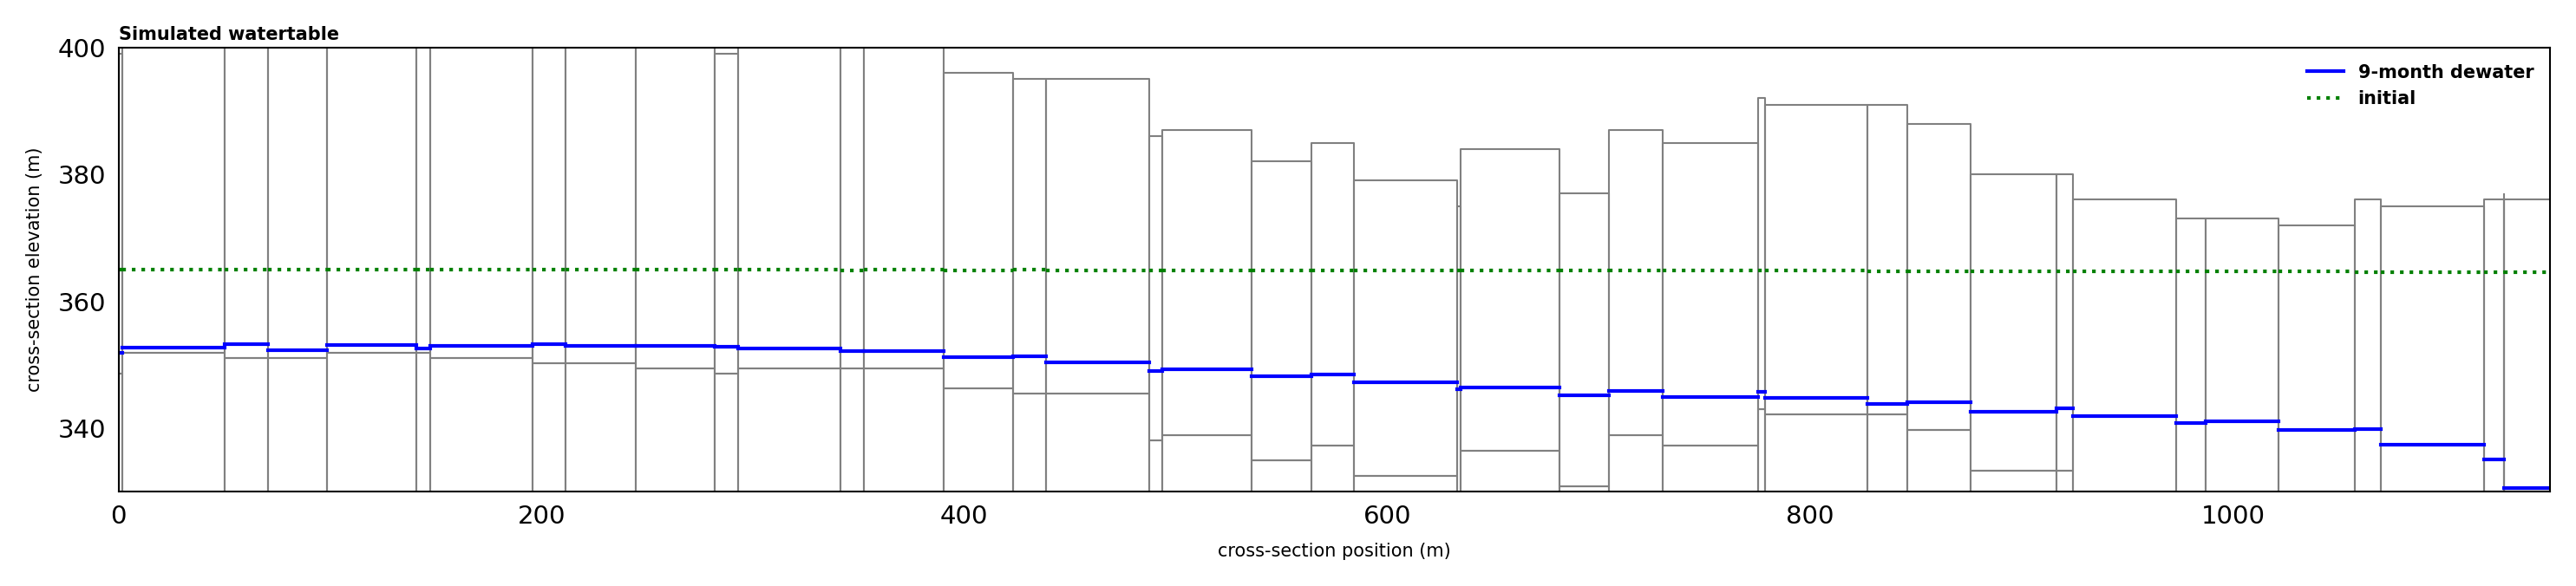

In [28]:
with styles.USGSMap():
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300, tight_layout=True)
    extent2 = (0.0,1150.0,330.0,400.0)
    xsect2 = flopy.plot.PlotCrossSection(modelgrid=mg, ax=ax, line=line, extent=extent2)
    # plot the surface and model grid
    xsect2.plot_surface(h0[0],color = "green", lw = 1.0, ls=':', label='initial')
    wt1 = xsect2.plot_surface(h[0], color="blue", lw=1.0, label='9-month dewater')
    grd = xsect2.plot_grid(lw=0.5) 
    #plt.legend()
   # set labels using styles
    styles.xlabel(label="x-position (m)")
    styles.ylabel(label="elevation (m)")
    styles.heading(heading="Simulated watertable",fontsize=5)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    leg = styles.graph_legend(handles = handles, labels=labels, fontsize=5)
    styles.remove_edge_ticks(ax=ax)
    styles.graph_legend_title(leg=leg,title="")
    styles.xlabel(ax=ax,label='cross-section position (m)',fontsize=5)
    styles.ylabel(ax=ax,label='cross-section elevation (m)',fontsize=5)
    ax.set_aspect(3.0)
plt.tight_layout()
fig.savefig(os.path.join(plots_f,'Dewater_cross_section2.png'),dpi=300)